#IMPORT LIBRARY

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

# LOAD DATASET

In [2]:
#Ambil dataset dari link diatas
from google.colab import drive
drive.mount('/content/drive')
link_data = "../content/drive/My Drive/Dataset/Gesture Image Pre-Processed Data"

Mounted at /content/drive


# SPLIT DATA TO DATA TRAIN : 80%, VALIDATION : 10%, And TEST : 10%

In [3]:
# Using module split-folders
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders

input_folder = "../content/drive/My Drive/Dataset/Gesture Image Pre-Processed Data"
output = "/content/dataset_kel_cv" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1), group_prefix = None)

Copying files: 6780 files [02:12, 51.32 files/s] 


In [5]:
#Create a variable to hold the train and validation data path
train_path = "/content/dataset_kel_cv/train"
test_path = "/content/dataset_kel_cv/test"
validation_path = "/content/dataset_kel_cv/val"  

# CREATE DATA AUGMENTATION

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(50,50),#Resizing all images to 50x50 pixels
    batch_size = 32,
    color_mode='rgb',
    class_mode = 'categorical' 
)

val_generator = val_data_generator.flow_from_directory(
    validation_path,
    target_size=(50,50),#Resizing all images to 50x50 pixels
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical' 
)

test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(50,50),#Resizing all images to 50x50 pixels
    batch_size = 32,
    color_mode = 'rgb',
    class_mode = 'categorical' 
)

Found 5424 images belonging to 37 classes.
Found 678 images belonging to 37 classes.
Found 678 images belonging to 37 classes.


# MODELING CNN

In [27]:
from tensorflow.keras import metrics, Sequential, layers
METRICS = [
    metrics.CategoricalAccuracy(name='categorical_accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')
]

model = Sequential([
    layers.Conv2D(32, (3, 3), activation = layers.ReLU(), padding = 'same', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(512, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation=layers.ReLU()),
    layers.Dense(256, activation=layers.ReLU()),
    layers.Dense(37, activation = 'softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)

# VISUALIZATION MODEL CNN

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


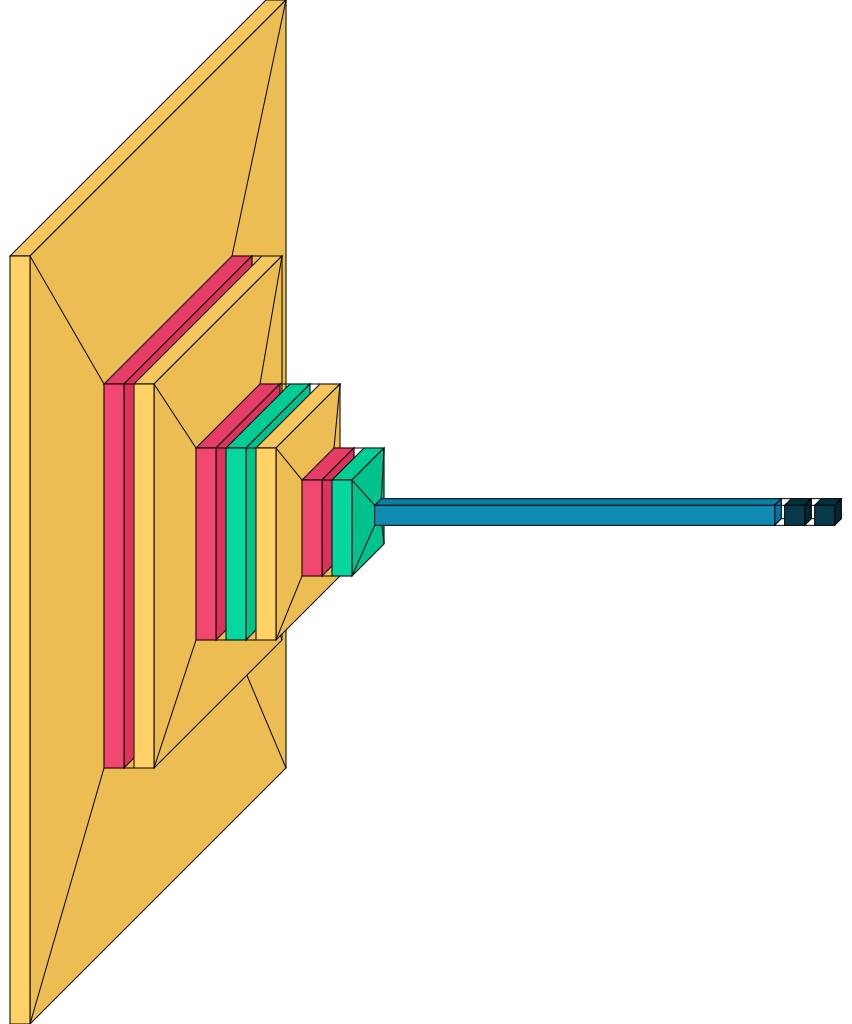

In [ ]:
import visualkeras
visualkeras.layered_view(model).show()

visualkeras.layered_view(model, to_file='MODEL_CNN_DICODING_ENDOW.png').show()

visualkeras.layered_view(model)

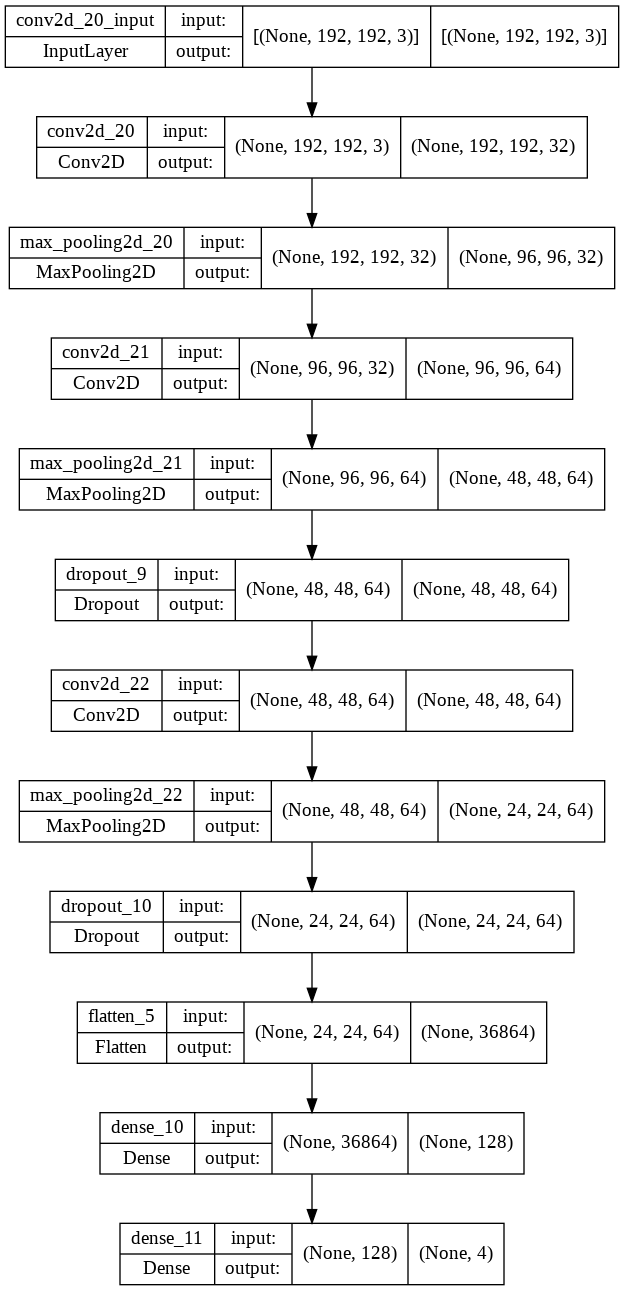

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='MODEL_CNN_DICODING_ENDOW.png', show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 64)       

# MODEL FITTING

In [28]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('categorical_accuracy') > 1.00 and logs.get('val_categorical_accuracy') > 1.00):
      print("\n Proses Training Di Stop Karena nilai akurasi dan validasi akurasi > 92%!")
      self.model.stop_training = True

my_callbacks = Callback()

In [29]:
hist = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=25,
    callbacks = [my_callbacks])

Epoch 1/25
170/170 [==============================] - 10s 50ms/step - loss: 0.7053 - categorical_accuracy: 0.7316 - precision: 0.8774 - recall: 0.6346 - auc: 0.9921 - prc: 0.8470 - val_loss: 0.0158 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/25
170/170 [==============================] - 8s 45ms/step - loss: 0.0503 - categorical_accuracy: 0.9827 - precision: 0.9845 - recall: 0.9816 - auc: 0.9994 - prc: 0.9969 - val_loss: 1.0594e-04 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/25
170/170 [==============================] - 8s 45ms/step - loss: 0.0224 - categorical_accuracy: 0.9932 - precision: 0.9939 - recall: 0.9932 - auc: 0.9997 - prc: 0.9987 - val_loss: 7.0824e-05 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 4/25
170/170 [==============================] 

# VISUALIZATION PLOT ACCURACY AND LOSS MODEL FITTING

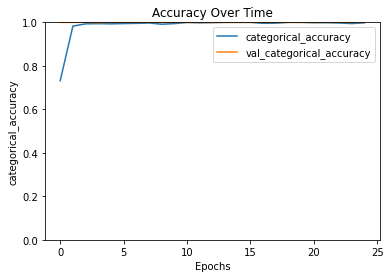

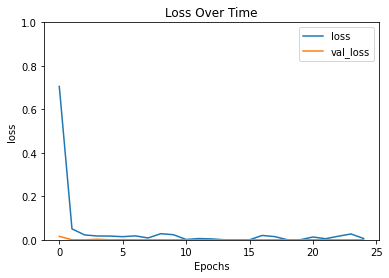

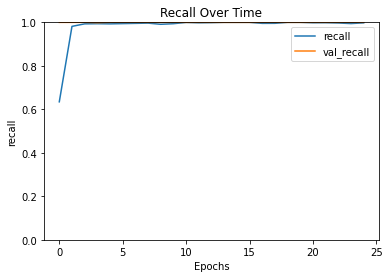

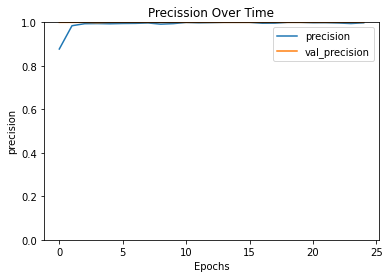

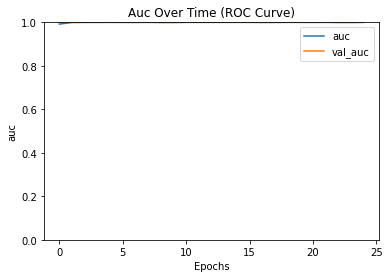

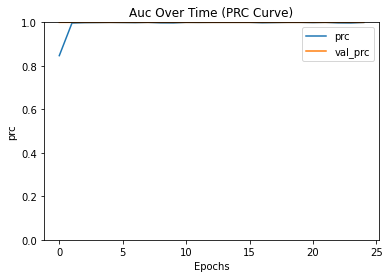

In [30]:
analisis_train = ['categorical_accuracy', 'loss', 'recall', 'precision', 'auc', 'prc']
analisis_val = ['val_categorical_accuracy', 'val_loss', 'val_recall','val_precision', 'val_auc', 'val_prc' ]
notes = ['Accuracy Over Time', 'Loss Over Time', 'Recall Over Time', 'Precission Over Time', 'Auc Over Time (ROC Curve)', 'Auc Over Time (PRC Curve)']

for analize in range(0, len(analisis_train)):
  plt.plot(hist.history[analisis_train[analize]], label=analisis_train[analize])
  plt.plot(hist.history[analisis_val[analize]], label = analisis_val[analize])
  plt.xlabel('Epochs')
  plt.ylabel(analisis_train[analize])
  plt.ylim(0, 1)
  plt.title(notes[analize])
  plt.legend()
  plt.show()

In [31]:
model.evaluate(train_generator) #Evaluasi Data Train

170/170 [==============================] - 7s 41ms/step - loss: 0.0023 - categorical_accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994 - auc: 0.9999 - prc: 0.9996


[0.0022664335556328297,
 0.9994469285011292,
 0.9994469285011292,
 0.9994469285011292,
 0.9999052882194519,
 0.9996489882469177]

In [32]:
model.evaluate(val_generator) #Evaluasi Data Validation

22/22 [==============================] - 0s 15ms/step - loss: 2.3560e-08 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


[2.3560495776564494e-08, 1.0, 1.0, 1.0, 1.0, 1.0]

# CONVERT TFLITE

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [34]:
# Menyimpan TFlite Model
with open('modelCV3.tflite', 'wb') as f:
  f.write(tflite_model)